# Stock Market Prediction

imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2024-07-27 18:34:52.245359: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-27 18:34:52.245468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-27 18:34:52.405164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
file_path = '/kaggle/input/stock-time-series-20050101-to-20171231/CAT_2006-01-01_to_2018-01-01.csv' 
data = pd.read_csv(file_path)

In [3]:
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,57.87,58.11,57.05,57.80,3697500,CAT
1,2006-01-04,57.95,59.43,57.55,59.27,4577200,CAT
2,2006-01-05,59.02,59.86,59.00,59.27,4590700,CAT
3,2006-01-06,59.47,60.76,59.38,60.45,5692300,CAT
4,2006-01-09,60.45,61.68,60.45,61.55,4409300,CAT


number of entries

In [4]:
len(data)

3020

Convert 'Date' to datetime format and set 'Date' as the index

In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [6]:
data.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,57.87,58.11,57.05,57.80,3697500,CAT
2006-01-04,57.95,59.43,57.55,59.27,4577200,CAT
2006-01-05,59.02,59.86,59.00,59.27,4590700,CAT
2006-01-06,59.47,60.76,59.38,60.45,5692300,CAT
2006-01-09,60.45,61.68,60.45,61.55,4409300,CAT


data statistics 

In [7]:
summary_statistics = data.describe()
summary_statistics

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3020.000000,3.020000e+03
mean,80.479881,81.304230,79.568470,80.480182,7.047746e+06
std,20.922491,20.916641,20.928699,20.945808,4.216400e+06
min,22.650000,23.290000,21.710000,22.170000,1.775920e+05
25%,68.445000,69.220000,67.610000,68.447500,4.463115e+06
50%,81.820000,82.580000,80.760000,81.765000,6.029723e+06
75%,93.660000,94.460000,92.805000,93.547500,8.464417e+06
max,158.050000,158.650000,157.510000,158.420000,6.780610e+07


In [8]:
missing_values = data.isnull().sum()
missing_values

Open      1
High      1
Low       1
Close     0
Volume    0
Name      0
dtype: int64

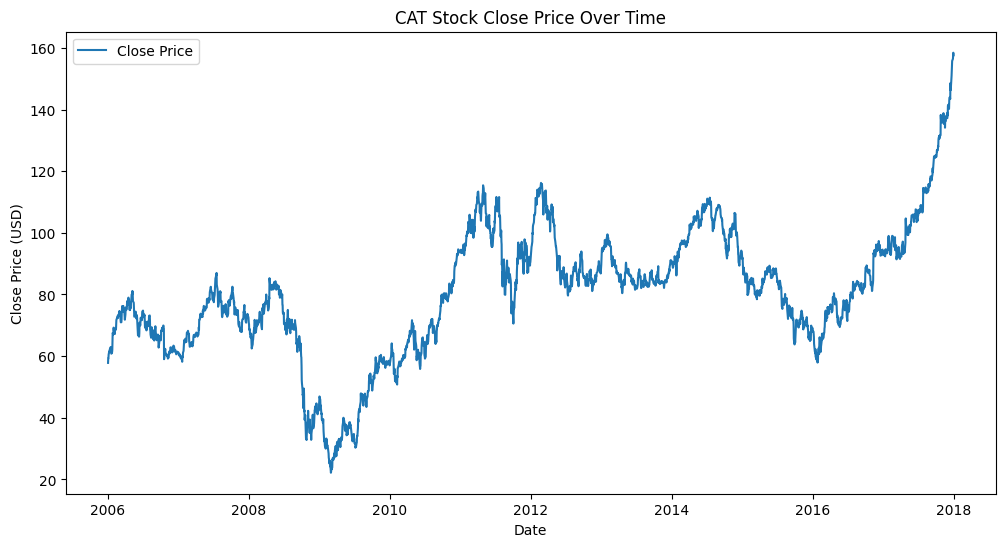

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price')
plt.title('CAT Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

In [10]:
data.fillna(method='ffill', inplace=True)

/tmp/ipykernel_34/2866031220.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [13]:
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data[['Open', 'High', 'Low', 'Close', 'Volume']])
scaled_test_data = scaler.transform(test_data[['Open', 'High', 'Low', 'Close', 'Volume']])

In [15]:
scaled_train_data = pd.DataFrame(scaled_train_data, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
scaled_test_data = pd.DataFrame(scaled_test_data, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

In [16]:
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length][3])  # The target is 'Close' price
    return np.array(X), np.array(y)

In [17]:
sequence_length = 60

X_train, y_train = create_sequences(scaled_train_data.values, sequence_length)
X_test, y_test = create_sequences(scaled_test_data.values, sequence_length)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2356, 60, 5)
(544, 60, 5)
(2356,)
(544,)


In [19]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 5)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0269
Epoch 2/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0049
Epoch 3/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0038
Epoch 4/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0037
Epoch 5/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0040
Epoch 6/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0035
Epoch 7/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0032
Epoch 8/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0033
Epoch 9/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0032
Epoch 10/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0030
Epoch 11/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0030
Epoch 12/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0029
Epoch 13/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0030
Epoch 14/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0025
Epoch 15/20
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0027
Epoc

In [22]:
loss = model.evaluate(X_test, y_test)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.3769e-04


In [23]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(
    np.hstack((np.zeros((predictions.shape[0], 3)), predictions, np.zeros((predictions.shape[0], 1)))))[:, 3]

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


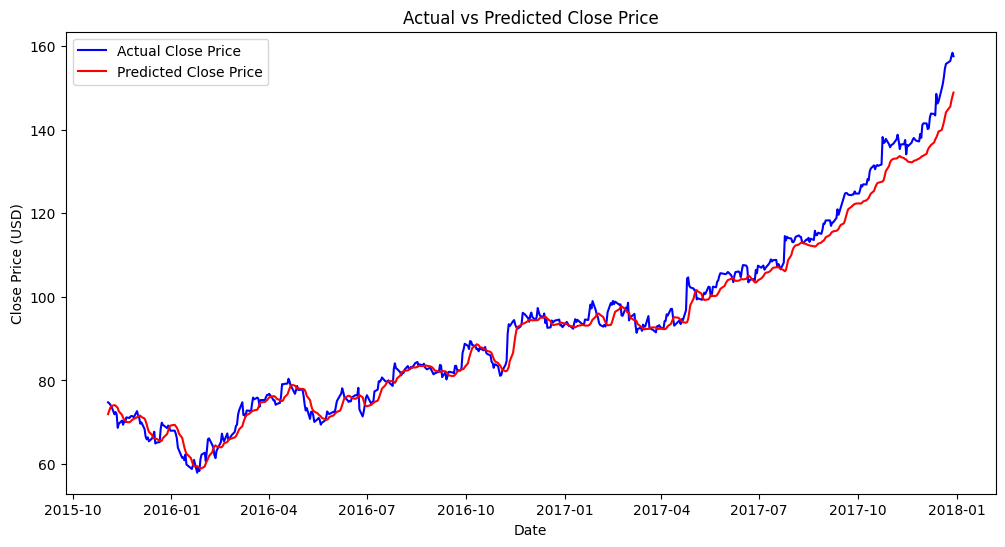

Test Loss: 0.0011525447480380535


In [24]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], data['Close'].values[-len(y_test):], color='blue', label='Actual Close Price')
plt.plot(data.index[-len(y_test):], predictions, color='red', label='Predicted Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

print('Test Loss:', loss)